In [5]:
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
#backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#visualization
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler
from qiskit.visualization import array_to_latex


In [6]:
#define unitary
def U(A,T,G):
    U = np.zeros((4,4), dtype=complex)
    
    U[0,0]=(-1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[0,3]=(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,1]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,2]=(-1+2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,1]=(-1-2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,2]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,0]=-(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,3]=(1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    return(U)

def Ureal(A,T,G):  #NUMERICALLY CHECKED, CORRECT#
    
    Ur = np.zeros((4,4), dtype=complex)
    
    coef1=np.sqrt(1+A**(2)*(4*np.cosh(G/2)**(2)*(1/np.sinh(T)**(2))+(1/np.cosh(T/2)**2)))
    
    coef2=np.sqrt(2*A**(2)*(np.cosh(G)+np.cosh(T))+np.sinh(T)**2)
    
    
    Ur[0,0]=(1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    Ur[0,3]=(2*A*np.sinh(T/2))/coef2
    
    Ur[1,1]=(2*A*np.cosh(T/2))/coef2
    
    Ur[1,2]=(1j + 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,1]=(1j - 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,2]=(2*A*np.cosh(T/2))/coef2
    
    Ur[3,0]=-(2*A*np.sinh(T/2))/coef2
    
    Ur[3,3]=(-1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    return(Ur)

def bwassembler(qc,matrix,layers,n):
    
    m=0
    while m < layers:
        i=0;j=0;    
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n))
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                qc.unitary(matrix,[2*j+1,0])
                
            else:
                qc.unitary(matrix, [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        m+=1
    
    return(qc)

def bwassembler_z(qc,matrix,layers,n):    #CHECKED#
    
    m=0
    while m < layers:
        i=0;j=0;    
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n)) 
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                
                qc.unitary(perm4site(matrix),[0,1,2,3],label='ZZ')
                
            else:
                qc.unitary(matrix, [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        m+=1
    
    return(qc)


def perm4site(U):   #CHECKED#
    
    P = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
    
    P12 = np.kron(P,np.eye(4))
    P23 = np.kron(np.eye(2),np.kron(P,np.eye(2)))
    P34 = np.kron(np.eye(4),P)
    S34 = np.kron(np.eye(4),U)
    
    return P12@P23@P34@S34@P34@P23@P12
       
    
def prodstaten(n):   #CHECKED#
    
    X = np.array([[0,1],[1,0]])
    X0 = np.zeros((n,2**n,2**n),dtype = complex)
    
    for i in range(0,n):   
        X0[i]=np.kron(np.kron(np.eye(2**i),X),np.eye(2**(n-i-1)))
    operator = np.eye(2**n)
    for i in range(0,n//2):
        operator = (X0[2*i]-1j*X0[2*i+1])@operator
    return (1/np.sqrt(2**(n//2)))*operator

def ry(T):
    return np.array([[np.cos(T/2),-np.sin(T/2)],[np.sin(T/2),np.cos(T/2)]])


Z = np.array([[1,0],[0,-1]]);


In [7]:

temp=np.kron(Z,np.kron(Z,np.kron(ry(np.pi/2),np.eye(2))))  
temp.shape

(16, 16)

In [41]:
#OTOC
#PLUS PART


def circ_plus(n,A,T,G,layers,pos):
    matrix = Ureal(A,T,G)
    q0 = QuantumCircuit(n)
    qc = QuantumCircuit(n)
    qcc = QuantumCircuit(n)
    circ = QuantumCircuit(n)
    
    #Zstring as pietro suggested
    #temp=np.kron(Z,np.kron(Z,np.kron(ry(np.pi/2),np.eye(2))))  
    #q0.unitary(temp,[0,1,2,3])
    
    #V_i perturbation pi/2
    q0.ry((np.pi/2),0,label='V_plus')
    qc.barrier(range(n))
    #fwd evolution
    matrix = Ureal(1,1,1)
    bwassembler_z(qc,matrix,layers,n)
    qcc.z(pos)
    qc.barrier(range(n))
    circ=qc.compose(qcc)
    circ=circ.compose(qc.inverse())
    q0 = q0.compose(circ)
    
    return q0



#OTOC
#MINUS PART


def circ_minus(n,A,T,G,layers,pos):
    
    matrix = Ureal(A,T,G)
    q0 = QuantumCircuit(n)
    qc = QuantumCircuit(n)
    qcc = QuantumCircuit(n)
    circ = QuantumCircuit(n)
    
    #perturbation with Z string
    #Zstring as pietro suggested
    #temp=np.kron(Z,np.kron(Z,np.kron(ry(-np.pi/2),np.eye(2))))  
    #q0.unitary(temp,[0,1,2,3])
    
    #V_i perturbation -pi/2
    q0.ry((-np.pi/2),0,label='V_minus')
    qc.barrier(range(n))
    #fwd evolution
    matrix = Ureal(1,1,1)
    bwassembler_z(qc,matrix,layers,n)
    qcc.z(pos)
    qc.barrier(range(n))
    circ=qc.compose(qcc)
    circ=circ.compose(qc.inverse())
    q0 = q0.compose(circ)
    
    return q0




#define operators to measure
def generate_pauli(n, j):
    if n <= 0 or j < 0 or  j >= n:
        raise ValueError("Invalid input values")
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position i and j
    pauli_str_list = list(pauli_str)
    pauli_str_list[j] = "X"
    pauli_str = "".join(pauli_str_list)
    op = SparsePauliOp(pauli_str, coeffs=[1])
    
    return op

def prodstaten(n):
    
    X = np.array([[0,1],[1,0]])
    X0 = np.zeros((n,2**n,2**n),dtype = complex)
    
    for i in range(0,n):   
        X0[i]=np.kron(np.kron(np.eye(2**i),X),np.eye(2**(n-i-1)))
    operator = np.eye(2**n)
    for i in range(0,n//2):
        operator = (X0[2*i]-1j*X0[2*i+1])@operator
    return (1/np.sqrt(2**(n//2)))*operator
    
def bell_pair1(qc, a, b):
    
    qc.h(a) # Put qubit a into state |+> or |-> using hadamard gate
    qc.cx(a,b) # CNOT with a as control and b as target
    
def bell_pair4(qc,a,b):
    
    qc.h(a)
    qc.x(b)
    qc.z(a)
    qc.z(b)
    qc.cx(a,b)
    

def perm4site(U):
    
    P = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
    
    P12 = np.kron(P,np.eye(4))
    P23 = np.kron(np.eye(2),np.kron(P,np.eye(2)))
    P34 = np.kron(np.eye(4),P)
    
    S34 = np.kron(np.eye(4),U)
    
    return P12@P23@P34@S34@P34@P23@P12

In [9]:
dispcolors = {'cx':('#426299', '#000000'),
              'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}
#qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

In [10]:
#sqrt(iSWAP)
sqiswap = np.array( [
    [1, 0, 0, 0],
    [0, 1/np.sqrt(2), 1j/np.sqrt(2), 0],
    [0, 1j/np.sqrt(2), 1/np.sqrt(2), 0],
    [0, 0, 0, 1] ])

In [5]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="b58a80862cd6d4e3f8618d0fb10c85a7415315bcf55dd407e498ce33bdd4709623e266b4fdee952700733135cd2fa847c7bffa65966a4efb0aa2ae6a4ad7b583", overwrite=True)

In [54]:
#MAIN (TROTTER)

#parameters
n,A,T,G=4,10,1,1
time=5
layer = 1
times = np.array([0,1,2,3,4])
thetas= np.arange(0.0001,0.5,0.1)
C = np.zeros((n,len(thetas)),dtype=float)

#specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

#settings job execution
options = Options()
options.execution.shots = 500
options.optimization_level = 1  # optimization
options.resilience_level = 1  # mitigation

for i in tqdm(range(0,n)):
    for k,theta in tqdm(enumerate(thetas)):
        trans_plus=circ_plus(n,A,theta/layer,G,layer,i)
        trans_minus=circ_minus(n,A,theta/layer,G,layer,i)
        
        
        #generate operator to measure
        op=generate_pauli(n,0)
        #runtime plus
        with Session(service=service, backend=backend) as session:
            estimator_sim = Estimator(session=session, options=options)
            job_sim = estimator_sim.run(circuits=[trans_plus], observables=[op])
            values_plus = job_sim.result().values
        #runtime minus
        with Session(service=service, backend=backend) as session:
            estimator_sim = Estimator(session=session, options=options)
            job_sim = estimator_sim.run(circuits=[trans_minus], observables=[op])
            values_minus = job_sim.result().values
        Corr = 2 + values_minus - values_plus
        C[i,k]=Corr

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:07,  7.14s/it]
2it [00:14,  7.23s/it]
3it [00:21,  7.06s/it]
4it [00:28,  7.02s/it]
5it [00:35,  7.02s/it]
 25%|█████████████████████▎                                                               | 1/4 [00:35<01:45, 35.09s/it]
0it [00:00, ?it/s]
1it [00:06,  6.93s/it]
2it [00:13,  6.85s/it]
3it [00:20,  6.76s/it]
4it [00:26,  6.70s/it]
5it [00:33,  6.70s/it]
 50%|██████████████████████████████████████████▌                                          | 2/4 [01:08<01:08, 34.17s/it]
0it [00:00, ?it/s]
1it [00:06,  6.91s/it]
2it [00:13,  6.99s/it]
3it [00:20,  6.86s/it]
4it [00:26,  6.58s/it]
5it [00:33,  6.75s/it]
 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [01:42<00:33, 33.97s/it]
0it [00:00, ?it/s]
1it [00:07,  7.41s/it]
2it [00:13,  6.86s/it]
3it [00:20,  6.87s/it]
4it [00:27,  6.99s/it]
5it

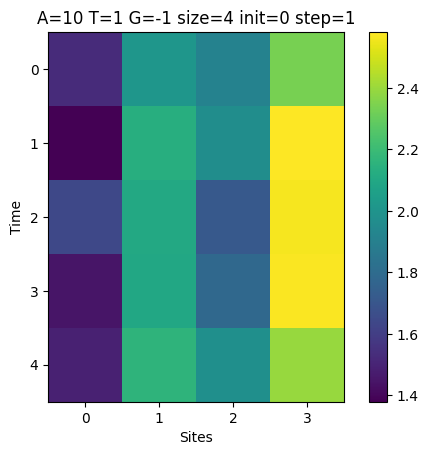

In [55]:
Cnew=np.flipud(np.transpose(C))
plt.imshow(Cnew)
plt.xlabel('Sites')
plt.ylabel('Time')
plt.title('A='+str(A)+' T='+str(T)+' G='+str(G)+' size='+str(n)+' init=0 step='+str(step))
plt.colorbar()


In [52]:
#MAIN 2 THE ONE THAT IS GONNA WORK (THETA SWEEP)
#theta0*layers=t
#parameters
n,A,G,step=4,10,0.01,1
times = [j for j in range(1,5)]

thetas= np.arange(0,2,0.5)
C = np.zeros((n,len(thetas)),dtype=float)


#specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("simulator_statevector")

#settings job execution
options = Options()
options.execution.shots = 4000
options.optimization_level = 1  # optimization
options.resilience_level = 1  # mitigation

for i in tqdm(range(0,n)):
    for k,theta in enumerate(tqdm(thetas)):
        
        trans_plus=circ_plus(n,A,theta,G,1,i)
        trans_minus=circ_minus(n,A,theta,G,1,i)
        
        
        #generate operator to measure
        op=generate_pauli(n,0)
        #runtime plus
        with Session(service=service, backend=backend) as session:
            estimator_sim = Estimator(session=session, options=options)
            job_sim = estimator_sim.run(circuits=[trans_plus], observables=[op])
            values_plus = job_sim.result().values
        #runtime minus
        with Session(service=service, backend=backend) as session:
            estimator_sim = Estimator(session=session, options=options)
            job_sim = estimator_sim.run(circuits=[trans_minus], observables=[op])
            values_minus = job_sim.result().values
        Corr = 2 + values_minus - values_plus
        C[i,k]=Corr

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_645/2684732895.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  coef1=np.sqrt(1+A**(2)*(4*np.cosh(G/2)**(2)*(1/np.sinh(T)**(2))+(1/np.cosh(T/2)**2)))
/tmp/ipykernel_645/2684732895.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  Ur[0,0]=(1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
/tmp/ipykernel_645/2684732895.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  Ur[1,2]=(1j + 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
/tmp/ipykernel_645/2684732895.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  Ur[2,1]=(1j - 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
/tmp/ipykernel_645/2684732895.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  Ur[3,3]=(-1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1

100%|████████████████████████████████████████████████████████████████████████████████████

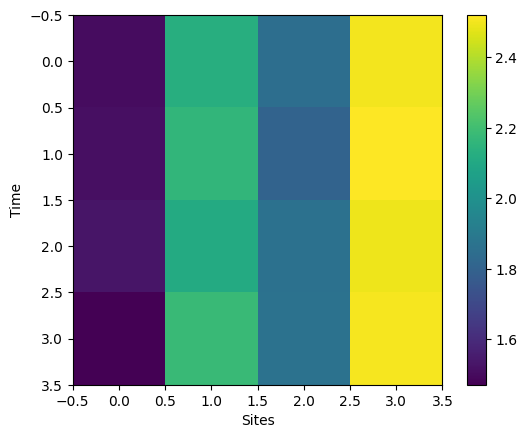

In [53]:
Cnew=np.flipud(np.transpose(C))
plt.imshow(Cnew)
plt.xlabel('Sites')
plt.ylabel('Time')
#plt.title('A='+str(A)+' T='+str(T)+' G='+str(G)+' size='+str(n)+' init='+str(init)+' step='+str(step))
plt.colorbar()

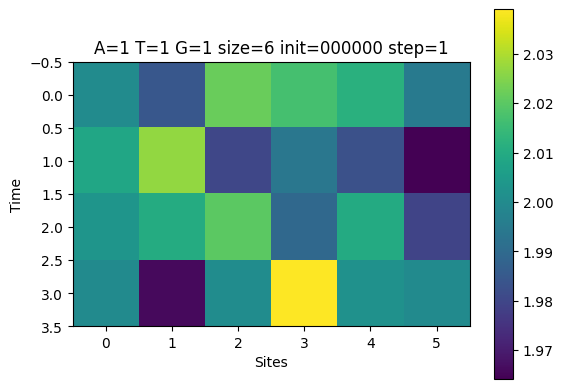

In [286]:
Cnew=np.flipud(np.transpose(C))
plt.imshow(Cnew)
plt.xlabel('Sites')
plt.ylabel('Time')
plt.title('A='+str(A)+' T='+str(T)+' G='+str(G)+' size='+str(n)+' init='+str(init)+' step='+str(step))
plt.colorbar()

In [83]:
generate_pauli(5,0)

SparsePauliOp(['XIIII'],
              coeffs=[10.+0.j])

In [ ]:
#saving data
with open('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n='+str(n)+' init: '+str(string), 'wb') as file:
      
    # A new file will be created
    pickle.dump(ent_entropy, file)

In [ ]:
#loading data
with open('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n=10', 'rb') as file:
    loaded_data = pickle.load(file)

## Reversibility of circuit test

In [73]:
n=4
layers=1
matrix=U(1,1,1)
qc=QuantumCircuit(n)
string = "1110" 
QuantumCircuit.initialize(qc,string)
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')


NameError: name 'dispcolors' is not defined

<IPython.core.display.Latex object>

# # Debug circuit 

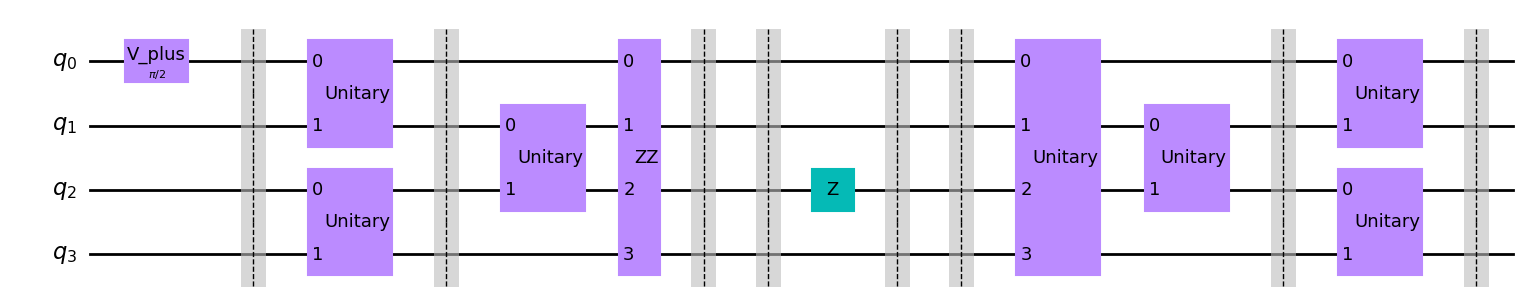

In [51]:
n,A,T,G,step,layers,pos=4,1,1,1,1,1,2
q0=circ_plus(n,A,T,G,layers,pos)
q0.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')    

In [87]:
qc = QuantumCircuit(4)
# Set the initial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**4)

# Evolve the state by the quantum circuit
state = state.evolve(prodstaten(4))


#draw using latex
state.draw('latex')

<IPython.core.display.Latex object>

In [92]:
mat1 = Operator(bwassembler_z(qc,matrix,1,4))

In [93]:
mat2 = Operator(revbwassembler_z(qc,matrix,1,4))

In [94]:
mat1=mat1.data
mat2=mat2.data

In [95]:
print(mat1@mat2)

[[-4.12883506e-01-8.08592174e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.07160052e-02-1.39627887e-01j
   0.00000000e+00+0.00000000e+00j -9.66707623e-18+7.85682431e-18j
   4.88290800e-02+2.53896975e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -4.88290800e-02-2.53896975e-01j
   2.37110117e-17+2.74293430e-17j  0.00000000e+00+0.00000000e+00j
  -1.07160052e-02-1.39627887e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -4.35406083e-17+5.28057061e-02j]
 [ 0.00000000e+00+0.00000000e+00j -1.42521109e-01+5.82285966e-01j
   2.29504477e-02-1.63814997e-01j  0.00000000e+00+0.00000000e+00j
  -8.19645215e-02-1.45783812e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  8.21407049e-02-1.73588659e-01j
  -1.51803238e-01-6.87754469e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.17429578e-17-6.39261658e-02j
   0.00000000e+00+0.00000000e+00j -4.40276301e-02+1.20782953e-01j
  -1.8761

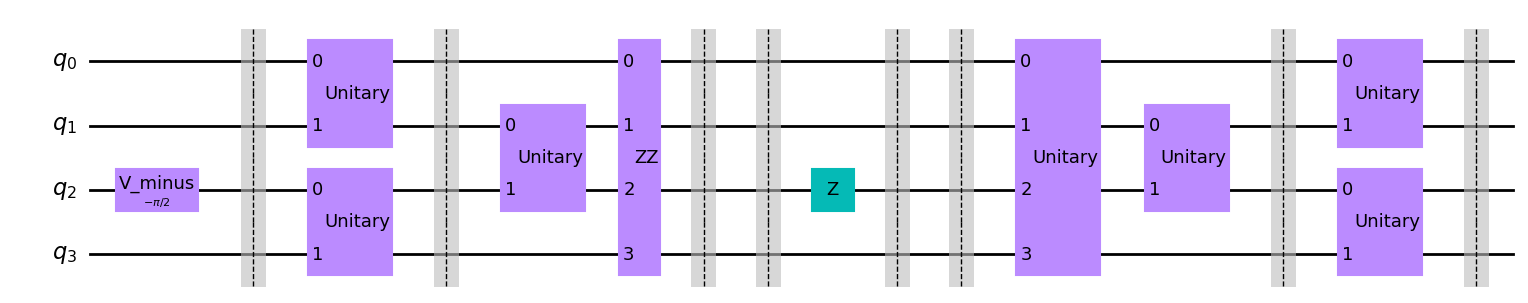

In [103]:
qc = QuantumCircuit(4)
qc=circ_minus(4,1,1,1,1,1,2)
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')    